# **Face Recognition in Google Colab**


In this tutorial we are gonna make a real time face recognition model that is gonna recognize a person only by training with one image!!! How cool is that! And this is now possible due the awesome library - "face-recognition". 

### Let's install all the necessary libraries at first

In [71]:
pip install cmake

In [72]:
pip install dlib

In [73]:
pip install face_recognition

In [74]:
pip install opencv-contrib-python

In [75]:
pip install imutils

In [76]:
pip install cmake==3.18.2.post1

In [77]:
pip install certifi==2020.6.20


In [78]:
pip install chardet==3.0.4


In [79]:
pip install click==7.1.2


In [80]:
pip install cmake==3.18.2.post1


In [81]:
pip install decorator==4.4.2


In [82]:
pip install dlib==19.18.0


In [83]:
pip install face-recognition==1.3.0


In [84]:
pip install face-recognition-models==0.3.0


In [85]:
pip install idna==2.10


In [86]:
pip install imageio==2.9.0


In [87]:
pip install imageio-ffmpeg==0.4.2


In [88]:
pip install moviepy==1.0.3


In [89]:
pip install numpy==1.19.2


In [90]:
pip install opencv-python==4.4.0.46


In [91]:
pip install Pillow==8.0.1


In [92]:
pip install proglog==0.1.9


In [93]:
pip install requests==2.23.0


In [94]:
pip install tqdm==4.51.0


In [95]:
pip install urllib3==1.25.11


In [96]:
pip install wincertstore==0.2

### Now let's import all those libraries

In [97]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import face_recognition
import os
from datetime import datetime


### It's time to write some code. 
If you are visiting my repo for the first time then let me tell you that I always do some tricky project so that I can learn something new and let other's have that same opportunity. I have chosen this project because I wanted to test how good face-recognition library is and also wanted to learn to access local device from cloud. Yes, as this project is being built on google colab which is a could platform, accessing my local webcam is a bit tricky here. For that I need to write JS code. Let's get on with this then.

In [98]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  img_as_array = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(img_as_array, flags=1)

  return img

In the above function, we are converting a JS object into an OpenCV image. By using b64decode library we are decoding the JS object into binary bytes. Then converting it into numpy array and from there we are again decoding it to image format. 

In [99]:
# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

This function will create an overlayed image of rectagular shape. We will add this image into the normal image captured by the webcam so that we can show the detected region into the image. 

In [100]:
def take_photo(filename='captured_image.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      div.appendChild(capture);
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  imgS = cv2.resize(img, (0, 0), None, 0.25, 0.25)
  imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)
  print(gray.shape)
  # get face bounding box coordinates using face-recognition library

  facesCurFrame = face_recognition.face_locations(imgS)
  encodesCurFrame = face_recognition.face_encodings(imgS, facesCurFrame)

  for encodeFace, faceLoc in zip(encodesCurFrame, facesCurFrame):
    matches = face_recognition.compare_faces(encodeListKnown, encodeFace)
    faceDis = face_recognition.face_distance(encodeListKnown, encodeFace)
    matchIndex = np.argmin(faceDis)


    if matches[matchIndex]:
      name = classNames[matchIndex].upper()
      # draw face bounding box on image
      y1, x2, y2, x1 = faceLoc
      y1, x2, y2, x1 = y1 * 4, x2 * 4, y2 * 4, x1 * 4
      img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
      img = cv2.rectangle(img, (x1, y2 - 35), (x2, y2), (0, 255, 0), cv2.FILLED)
      img = cv2.putText(img, name, (x1 + 6, y2 - 6), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
          

    else:
      print("Face is not detecting")
 
  # save image
  cv2.imwrite(filename, img)

  return filename



In this function we are using JS to take picture using our webcam. Then we are using face-recognition library to detect the face and putting rectangle box into that image using openCV. 

To give users a feel of real time we are taking a video stream also. When the user clicks on the capture button only then the image is taken and shown.

<IPython.core.display.Javascript object>

(480, 640)
Saved to captured_image.jpg


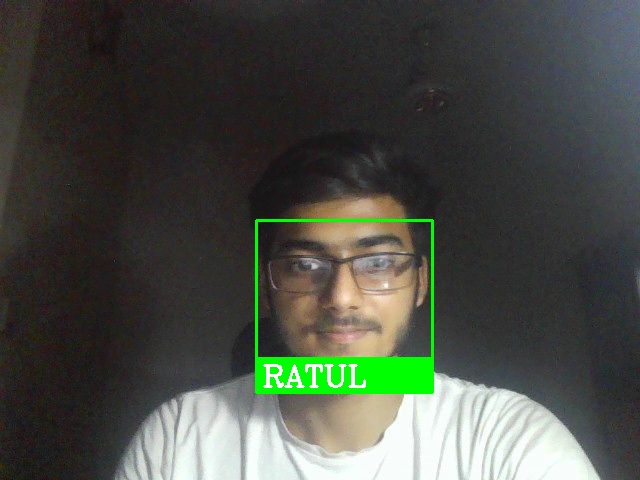

In [101]:

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [102]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

This is our main function of today's tutorial. Using this JS based function we are taking real time video stream from our local webcam. If you do this project into your local IDE then this function will take only 2 lines of code in python. But as we are using cloud, we cannot not access our webcam using that code. For that we need to use this JS code. You can change the shape of the video screen and quality and everything as per your wish. Just remember that the screen size should be proportional. Because we want to overlay our detected rectangular box into the video screen here. If the size does not match with the image then it will not show at the right position. 

### Now it's time to train our model and show the real time face detection

In [103]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Streaming...'
# initialze bounding box to empty
bbox = ''
count = 0 



# from PIL import ImageGrab

path = '/media'
images = []
imageNames = []
imageList = os.listdir(path)
print(imageList)
for image in imageList:
    currentImg = cv2.imread(f'{path}/{image}')
    images.append(currentImg)
    imageNames.append(os.path.splitext(image)[0])
print(imageNames)


def findEncodings(images):
    encodeList = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encode = face_recognition.face_encodings(img)[0]
        encodeList.append(encode)
    print('Encoding Complete')
    return encodeList



#### FOR CAPTURING SCREEN RATHER THAN WEBCAM
#def captureScreen(bbox=(300,300,690+300,530+300)):
  #capScr = np.array(ImageGrab.grab(bbox))
  #capScr = cv2.cvtColor(capScr, cv2.COLOR_RGB2BGR)
  #return capScr

encodeListKnown = findEncodings(images)


while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)


    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    imgS = cv2.resize(img, (0, 0), None, 0.25, 0.25)
    imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)

    # get face region coordinates

    facesCurFrame = face_recognition.face_locations(imgS)
    encodesCurFrame = face_recognition.face_encodings(imgS, facesCurFrame)

    for encodeFace, faceLoc in zip(encodesCurFrame, facesCurFrame):
        matches = face_recognition.compare_faces(encodeListKnown, encodeFace)
        faceDis = face_recognition.face_distance(encodeListKnown, encodeFace)
        matchIndex = np.argmin(faceDis)

        if matches[matchIndex]:
          name = classNames[matchIndex].upper()
          y1, x2, y2, x1 = faceLoc
          y1, x2, y2, x1 = y1 * 4, x2 * 4, y2 * 4, x1 * 4
          bbox_array = cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
          bbox_array = cv2.rectangle(bbox_array, (x1, y2 - 35), (x2, y2), (0, 255, 0), cv2.FILLED)
          bbox_array = cv2.putText(bbox_array, name, (x1 + 4, y2 - 6), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)

        else:
          print("Face is not detecting")

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

['Ertugrul.jpg', 'Ratul.jpg', 'Rittik.jpg']
['Ertugrul', 'Ratul', 'Rittik']
Encoding Complete


## That's how it is done! Hope you have enjoyed this tutorial.